In [2]:
# SIMULATED DATA EXPERIMENTS
# RUN WITH python run_sim_experiments_dfNGP.py
# 
#       ooooooooooooooooooooooooooooooooooooo
#      8                                .d88
#      8  oooooooooooooooooooooooooooood8888
#      8  8888888888888888888888888P"   8888    oooooooooooooooo
#      8  8888888888888888888888P"      8888    8              8
#      8  8888888888888888888P"         8888    8             d8
#      8  8888888888888888P"            8888    8            d88
#      8  8888888888888P"               8888    8           d888
#      8  8888888888P"                  8888    8          d8888
#      8  8888888P"                     8888    8         d88888
#      8  8888P"                        8888    8        d888888
#      8  8888oooooooooooooooooooooocgmm8888    8       d8888888
#      8 .od88888888888888888888888888888888    8      d88888888
#      8888888888888888888888888888888888888    8     d888888888
#                                               8    d8888888888
#         ooooooooooooooooooooooooooooooo       8   d88888888888
#        d                       ...oood8b      8  d888888888888
#       d              ...oood888888888888b     8 d8888888888888
#      d     ...oood88888888888888888888888b    8d88888888888888
#     dood8888888888888888888888888888888888b
#
#
# This artwork is a visual reminder that this script is for the sim experiments.

model_name = "dfNGP"

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY
# also import x_test grid size and std noise for training data
from configs import N_SIDE, STD_GAUSSIAN_NOISE

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = NUM_RUNS
NUM_RUNS = 1
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_SIM_LEARNING_RATE")
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")
import os
os.makedirs(MODEL_SIM_RESULTS_DIR, exist_ok = True)

# imports for probabilistic models
if model_name in ["GP", "dfGP", "dfNGP"]:
    from GP_models import GP_predict
    from metrics import compute_NLL_sparse, compute_NLL_full
    from configs import L_RANGE, SIGMA_N_RANGE, GP_PATIENCE
    # overwrite with GP_PATIENCE
    PATIENCE = GP_PATIENCE
    if model_name in ["dfGP", "dfNGP"]:
        from configs import SIGMA_F_RANGE

# for all models with NN components train on batches
if model_name in ["dfNGP", "dfNN", "PINN"]:
    from configs import BATCH_SIZE

if model_name in ["dfNGP", "dfNN"]:
    from NN_models import dfNN

# universals 
from metrics import compute_RMSE, compute_MAE, compute_divergence_field

# basics
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker

# utilitarian
from utils import set_seed, make_grid
# reproducibility
set_seed(42)
import gc

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
tracker = EmissionsTracker(project_name = "dfNGP_simulation_experiments", output_dir = MODEL_SIM_RESULTS_DIR)
tracker.start()

### SIMULATION ###
# Import all simulation functions
from simulate import (
    simulate_detailed_branching,
    # simulate_detailed_convergence,
    simulate_detailed_curve,
    simulate_detailed_deflection,
    simulate_detailed_edge,
    simulate_detailed_ridges,
)

# Define simulations as a dictionary with names as keys to function objects
# alphabectic order here
simulations = {
    "curve": simulate_detailed_curve,
}

########################
### x_train & x_test ###
########################

# Load training inputs (once for all simulations)
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Generate x_test (long) once for all simulations
_, x_test = make_grid(N_SIDE)
# x_test is long format (N_SIDE ** 2, 2)

#################################
### LOOP 1 - over SIMULATIONS ###
#################################

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    ########################
    ### y_train & y_test ###
    ########################

    # Generate training observations
    # NOTE: sim_func() needs to be on CPU, so we move x_train to CPU
    y_train = sim_func(x_train.cpu()).to(device)
    y_test = sim_func(x_test.cpu()).to(device)
    
    # x_test = x_test.to(device).requires_grad_(True)
    x_test = x_test.to(device)
    # x_train = x_train.to(device).requires_grad_(True)
    x_train = x_train.to(device)

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print(f"Training inputs device: {y_train.device}")
    print(f"Training observations device: {y_train.device}")
    print()

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print(f"Test inputs device: {x_test.device}")
    print(f"Test observations device: {y_test.device}")
    print()

    # NOTE: This is different to the real data experiments
    # calculate the mean magnitude of the test data as we use this to scale the noise
    sim_mean_magnitude_for_noise = torch.norm(y_test, dim = -1).mean().to(device)
    sim_noise = STD_GAUSSIAN_NOISE * sim_mean_magnitude_for_noise

    # Store metrics for the simulation (used for *metrics_summary* report and *metrics_per_run*)
    simulation_results = [] 

    ##################################
    ### LOOP 2 - over training run ###
    ##################################
    
    # NOTE: GPs and hense dfNGPs don't train on batches, use full data

    for run in range(NUM_RUNS):

        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # initialise trainable dfGP params
        sigma_n = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_N_RANGE))
        sigma_f = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_F_RANGE))
        l = nn.Parameter(torch.empty(2, device = device).uniform_( * L_RANGE))

        # For every run initialise a (new) mean model
        dfNN_mean_model = dfNN().to(device)

        # NOTE: We don't need a criterion either

        # AdamW as optimizer for some regularisation/weight decay
        # HACK: create two param groups: one for the dfNN and one for the hypers
        optimizer = optim.AdamW([
            {"params": dfNN_mean_model.parameters(), "weight_decay": WEIGHT_DECAY, "lr": (0.1 * MODEL_LEARNING_RATE)},
            {"params": [sigma_n, sigma_f, l], "weight_decay": WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])

        # _________________
        # BEFORE EPOCH LOOP
        
        # Export the convergence just for first run only
        if run == 0:
            # initialise tensors to store losses over epochs (for convergence plot)
            train_losses_NLML_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # objective
            train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # by-product
            # monitor performance transfer to test (only RMSE easy to calc without covar)
            test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

            sigma_n_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            sigma_f_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l1_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l2_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        # counter starts at 0
        epochs_no_improve = 0

        # NOTE: This is a difference to the real data experiments
        # Additive noise model: independent Gaussian noise
        # For every run we have a FIXED NOISY TARGET. Draw from standard normal with appropriate std
        y_train_noisy = y_train + (torch.randn(y_train.shape, device = device) * sim_noise)

        ############################
        ### LOOP 3 - over EPOCHS ###
        ############################
        
        print("\nStart Training")

        for epoch in range(MAX_NUM_EPOCHS):

            # Assure model is in training mode
            dfNN_mean_model.train()

            # For Run 1 we save a bunch of metrics and update, while for the rest we only update
            if run == 0:
                mean_pred_train, _, lml_train = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_train, # predict training data
                        [sigma_n, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel

                # Compute test loss for loss convergence plot
                mean_pred_test, _, _ = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_test.to(device), # have predictions for training data again
                        # HACK: This is rather an eval, so we use detached hypers to avoid the computational tree
                        [sigma_n.detach().clone(), sigma_f.detach().clone(), l.detach().clone()], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML. loss is always on train
                loss = - lml_train
                loss.backward()
                optimizer.step()
                
                # NOTE: it is important to detach here 
                train_RMSE = compute_RMSE(y_train.detach(), mean_pred_train.detach())
                test_RMSE = compute_RMSE(y_test.detach(), mean_pred_test.detach())

                # Save losses for convergence plot
                train_losses_NLML_over_epochs[epoch] = - lml_train
                train_losses_RMSE_over_epochs[epoch] = train_RMSE
                # NOTE: lml is always just given training data. There is no TEST NLML
                test_losses_RMSE_over_epochs[epoch] = test_RMSE

                # Save evolution of hyprs for convergence plot
                sigma_n_over_epochs[epoch] = sigma_n[0]
                sigma_f_over_epochs[epoch] = sigma_f[0]
                l1_over_epochs[epoch] = l[0]
                l2_over_epochs[epoch] = l[1]

                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}")

                # delete after printing and saving
                # NOTE: keep loss for early stopping check
                del mean_pred_train, mean_pred_test, lml_train, train_RMSE, test_RMSE
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()
            
             # For all runs after the first we run a minimal version using only lml_train
            else:

                # NOTE: We can use x_train[0:2] since the predictions doesn;t matter and we only care about lml_train
                _, _, lml_train = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_train[0:2], # predictions don't matter and we output lml_train already
                        [sigma_n, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML
                loss = - lml_train
                loss.backward()
                optimizer.step()

                # After run 1 we only print lml, nothing else
                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}")

                # NOTE: keep loss for early stopping check, del lml_train
                del lml_train
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()

            # EVERY EPOCH: Early stopping check
            if loss < best_loss:
                best_loss = loss
                # reset counter if loss improves
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                # exit epoch loop
                break

        ##############################
        ### END LOOP 3 over EPOCHS ###
        ##############################

        # for every run...
        #######################################################
        ### EVALUATE after all training for RUN is finished ###
        #######################################################

        # Evaluate the trained model after all epochs are finished or early stopping was triggered
        # NOTE: Detach tuned hyperparameters from the computational graph
        best_sigma_n = sigma_n.detach().clone()
        best_sigma_f = sigma_f.detach().clone()
        best_l = l.detach().clone()

        # Need gradients for autograd divergence: We clone and detach
        x_test_grad = x_test.to(device).clone().requires_grad_(True)

        mean_pred_test, covar_pred_test, _ = GP_predict(
            x_train,
            y_train, # NOTE: use original y_train, not noisy
            x_test_grad,
            [best_sigma_n, best_sigma_f, best_l], # list of (initial) hypers
            mean_func = dfNN_mean_model, # dfNN as mean function
            divergence_free_bool = True) # ensures we use a df kernel
        
        # Compute divergence field
        dfNGP_test_div_field = compute_divergence_field(mean_pred_test, x_test_grad)

        # Only save mean_pred, covar_pred and divergence fields for the first run
        if run == 0:

            # (1) Save predictions from first run so we can visualise them later
            torch.save(mean_pred_test, f"{MODEL_SIM_RESULTS_DIR}/{sim_name}_{model_name}_test_mean_predictions.pt")
            torch.save(covar_pred_test, f"{MODEL_SIM_RESULTS_DIR}/{sim_name}_{model_name}_test_covar_predictions.pt")

            # (2) Save best hyperparameters
            # Stack tensors into a single tensor
            best_hypers_tensor = torch.cat([
                best_sigma_n.reshape(-1),  # Ensure 1D shape
                best_sigma_f.reshape(-1),
                best_l.reshape(-1),
            ])

            torch.save(best_hypers_tensor, f"{MODEL_SIM_RESULTS_DIR}/{sim_name}_{model_name}_best_hypers.pt")

            # (3) Since all epoch training is finished, we can save the losses over epochs
            df_losses = pd.DataFrame({
                'Epoch': list(range(train_losses_NLML_over_epochs.shape[0])), # pythonic indexing
                'Train Loss NLML': train_losses_NLML_over_epochs.tolist(),
                'Train Loss RMSE': train_losses_RMSE_over_epochs.tolist(),
                'Test Loss RMSE': test_losses_RMSE_over_epochs.tolist(),
                'Sigma_n': sigma_n_over_epochs.tolist(),
                'Sigma_f': sigma_f_over_epochs.tolist(),
                'l1': l1_over_epochs.tolist(),
                'l2': l2_over_epochs.tolist()
                })
            
            df_losses.to_csv(f"{MODEL_SIM_RESULTS_DIR}/{sim_name}_{model_name}_losses_over_epochs.csv", index = False, float_format = "%.5f") # reduce to 5 decimals for readability

            # (4) Save divergence field (computed above for all runs)
            torch.save(dfNGP_test_div_field, f"{MODEL_SIM_RESULTS_DIR}/{sim_name}_{model_name}_test_prediction_divergence_field.pt")

        x_train_grad = x_train.to(device).clone().requires_grad_(True)

        mean_pred_train, covar_pred_train, _ = GP_predict(
                     x_train,
                     y_train, # NOTE: use original y_train, not noisy
                     x_train_grad,
                     [best_sigma_n, best_sigma_f, best_l], # list of (initial) hypers
                     mean_func = dfNN_mean_model, # dfNN as mean function
                     divergence_free_bool = True) # ensures we use a df kernel
        
        dfNGP_train_div_field = compute_divergence_field(mean_pred_train, x_train_grad)

        # Divergence: Convert field to metric: mean absolute divergence
        # NOTE: It is important to use the absolute value of the divergence field, since positive and negative deviations are violations and shouldn't cancel each other out 
        dfNGP_train_div = dfNGP_train_div_field.abs().mean().item()
        dfNGP_test_div = dfNGP_test_div_field.abs().mean().item()

        # Compute metrics (convert tensors to float) for every run's tuned model
        dfNGP_train_RMSE = compute_RMSE(y_train, mean_pred_train).item()
        dfNGP_train_MAE = compute_MAE(y_train, mean_pred_train).item()
        dfNGP_train_NLL = compute_NLL_sparse(y_train, mean_pred_train, covar_pred_train).item()
        dfNGP_train_full_NLL = compute_NLL_full(y_train, mean_pred_train, covar_pred_train).item()

        dfNGP_test_RMSE = compute_RMSE(y_test, mean_pred_test).item()
        dfNGP_test_MAE = compute_MAE(y_test, mean_pred_test).item()
        dfNGP_test_NLL = compute_NLL_sparse(y_test, mean_pred_test, covar_pred_test).item()
        dfNGP_test_full_NLL = compute_NLL_full(y_test, mean_pred_test, covar_pred_test).item()

[codecarbon INFO @ 06:46:02] [setup] RAM Tracking...
[codecarbon INFO @ 06:46:02] [setup] CPU Tracking...
[codecarbon WARNING @ 06:46:02] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Using device: cuda



[codecarbon WARNING @ 06:46:04] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:46:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
[codecarbon INFO @ 06:46:04] [setup] GPU Tracking...
[codecarbon INFO @ 06:46:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:46:04] >>> Tracker's metadata:
[codecarbon INFO @ 06:46:04]   Platform system: Linux-5.15.0-134-generic-x86_64-with-glibc2.31
[codecarbon INFO @ 06:46:04]   Python version: 3.9.20
[codecarbon INFO @ 06:46:04]   CodeCarbon version: 2.8.4
[codecarbon INFO @ 06:46:04]   Available RAM : 62.767 GB
[codecarbon INFO @ 06:46:04]   CPU count: 40
[codecarbon INFO @ 06:46:04]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
[codecarbon INFO @ 06:46:04]   GPU count: 1
[codecarbon INFO @ 06:46:04]   GPU model: 1 x NVIDIA GeForce RTX 4090
[codecarbon INFO @ 06:46:07] Emissions data (if any) will be saved to file /hom

=== CURVE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32
Training inputs device: cuda:0
Training observations device: cuda:0

=== CURVE ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32
Test inputs device: cuda:0
Test observations device: cuda:0


--- Training Run 1/1 ---

Start Training
curve dfNGP Run 1/1, Epoch 1/2000, Training Loss (NLML): -106.2010, (RMSE): 0.0887
curve dfNGP Run 1/1, Epoch 2/2000, Training Loss (NLML): -264.0489, (RMSE): 0.0891
curve dfNGP Run 1/1, Epoch 3/2000, Training Loss (NLML): -347.9341, (RMSE): 0.0888
curve dfNGP Run 1/1, Epoch 4/2000, Training Loss (NLML): -391.5256, (RMSE): 0.0880
curve dfNGP Run 1/1, Epoch 5/2000, Training Loss (NLML): -414.9910, (RMSE): 0.0867
curve dfNGP Run 1/1, Epoch 6/2000, Training Loss (NLML): -427.9481, (RMSE): 0.0852
curve dfNGP Run 1/1, Epoch 7/2000, Training Loss (NL

SystemExit: 1

/home/kim/ice_thickness/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
a = torch.tensor([0, 1])
b = torch.tensor([2, 3, 4])
listi = [a, b]

In [10]:
len(listi)
type(listi)

list

In [3]:
import torch
torch.log(torch.tensor(2 * torch.pi))

tensor(1.8379)

In [ ]:
def compute_NLL_sparse(y_true, y_mean_pred, y_covar_pred):
    """ Computes a sparse version of the Negative Log-Likelihood (NLL) for a 2D Gaussian distribution. This sparse version neglects cross-covariance terms and is more efficient for large datasets.
    
    NLL: The NLL quantifies how well the predicted Gaussian distribution fits the observed data.
    Sparse format: each of the N points has its own 2×2 covariance matrix. (This is more than just the diagonal of the covariance matrix, but not the full covar.)

    Args:
        y_true (torch.Tensor): True observations of shape (N, 2).
        y_mean_pred (torch.Tensor): Mean predictions of shape (N, 2).
        y_covar_pred (torch.Tensor): Full predicted covariance matrix of shape (N * 2, N * 2).(BLOCK FORMAT) [u1, u2, u3, ..., v1, v2, v3, ...]
            If N = 400, then y_covar_pred is torch.Size([800, 800]) so 640000 elements N x 2 x 2 = only 1600 elements.
        jitter (float, optional): Small value added to the diagonal for numerical stability. Defaults to 0.5 * 1e-2 - quite high but we need to keep it consistent across all models.

    Returns:
        torch.Tensor(): Negative Log-Likelihood (NLL) scalar.
    """
    # Extract number of points
    N = y_true.shape[0]

    # Step 1: Sparsify the covariance matrix
    # Change format of y_covar_pred from (N x 2, N x 2) to (N, 2, 2) so N (2, 2) matrices.
    # NOTE: This is a sparse version of the covariance matrix, neglecting cross-covariance terms.

    # extract diagonal of upper left quadrant: variance of the first output (y1) at each point.
    var_y1_y1 = torch.diag(y_covar_pred[:N, :N])
    # extract diagonal of ulower right quadrant: variance of the second output (y2) at each point
    var_y2_y2 = torch.diag(y_covar_pred[N:, N:])

    # extract diagonal of upper right quadrant: How much do y1 and y2 covary at this point
    covar_y1_y2 = torch.diag(y_covar_pred[:N, N:])
    # extract diagonal of lower left quadrant
    covar_y2_y1 = torch.diag(y_covar_pred[N:, :N])

    col1 = torch.cat([var_y1_y1.unsqueeze(-1), covar_y1_y2.unsqueeze(-1)], dim = -1)
    col2 = torch.cat([covar_y2_y1.unsqueeze(-1), var_y2_y2.unsqueeze(-1)], dim = -1)

    # At each point N, what is the predicted variance of y1 and y2 and 
    # what is the predicted covariance between y1 and y2? (symmetric)
    covar_N22 = torch.cat([col1.unsqueeze(-1), col2.unsqueeze(-1)], dim = -1) # shape: torch.Size([N, 2, 2])


    # STEP 2: Compute Mahalanobis distance efficiently
    # Compute the difference between the true and predicted values (y - μ)
    # NOTE: order is (true - pred) to match the Mahalanobis distance formula
    # NOTE: we can also keep this shape
    diff = y_true - y_mean_pred   # Shape: (N, 2)
    
    # Reshape diff to (N, 2, 1) to do matrix multiplication with (N, 2, 2)
    diff = diff.unsqueeze(-1)  # shape: (N, 2, 1)

    sigma_inverse = torch.inverse(covar_N22) # shape: torch.Size([N, 2, 2])

    # Compute (Σ⁻¹ @ diff) → shape: (N, 2, 1)
    maha_component = torch.matmul(sigma_inverse, diff)

    # Compute (diff^T @ Σ⁻¹ @ diff) for each point → shape: (N, 1, 1)
    # transpose diff to (N, 1, 2) for matrix multiplication
    mahalanobis_distances = torch.matmul(diff.transpose(1, 2), maha_component)

    # Sum (N, ) distances to get a single value
    mahalanobis_distances = mahalanobis_distances.squeeze().sum()

    # STEP 3: Log determinant of the covariance matrix

    # element-wise determinant of all 2x2 matrices: sum
    sign, log_absdet = torch.slogdet(covar_N22)
    if not torch.all(sign > 0):
        print("Warning: Non-positive definite matrix encountered.")
        return torch.tensor(float("inf"), device = covar_N22.device)
    log_det_Sigma = log_absdet.sum()


    # STEP 4: Compute normalisation term
    d = N * 2  # Dimensionality (since we have two outputs per point)
    normalisation_term = d * torch.log(torch.tensor(2 * torch.pi, device = y_true.device))

    # Step 5: Combine 3 scalars into negative log-likelihood (NLL)
    # Gaussian log-likelihood formula: 2D
    # NOTE: Gaussian log-likelihood 2D formula
    log_likelihood =  - 0.5 * (mahalanobis_distances + log_det_Sigma + normalisation_term)

    # return the negative log-likelihood
    # return - log_likelihood
    return covar_N22

func_N22 = compute_NLL_sparse(y_test, mean_pred_test, covar_pred_test)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(covar_pred_test.cpu().detach(), cmap='viridis')

In [66]:
# REAL DATA EXPERIMENTS
# RUN WITH python run_real_experiments_dfGP.py
#               _                 _   _      
#              | |               | | (_)     
#    __ _ _ __ | |_ __ _ _ __ ___| |_ _  ___ 
#   / _` | '_ \| __/ _` | '__/ __| __| |/ __|
#  | (_| | | | | || (_| | | | (__| |_| | (__ 
#   \__,_|_| |_|\__\__,_|_|  \___|\__|_|\___|
# 
model_name = "dfGP"

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = NUM_RUNS
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# TODO: Delete overwrite, run full
NUM_RUNS = 1

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_REAL_LEARNING_RATE")
MODEL_REAL_RESULTS_DIR = getattr(configs, f"{model_name}_REAL_RESULTS_DIR")
import os
os.makedirs(MODEL_REAL_RESULTS_DIR, exist_ok = True)

# imports for probabilistic models
if model_name in ["GP", "dfGP", "dfNGP"]:
    from GP_models import GP_predict
    from metrics import compute_NLL_sparse, compute_NLL_full
    from configs import L_RANGE, GP_PATIENCE
    # overwrite with GP_PATIENCE
    PATIENCE = GP_PATIENCE
    
    if model_name in ["dfGP", "dfNGP"]:
        from configs import SIGMA_F_RANGE

# universals 
from metrics import compute_RMSE, compute_MAE, compute_divergence_field

# basics
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker

# utilitarian
from utils import set_seed
# reproducibility
set_seed(42)
import gc

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
# tracker = EmissionsTracker(project_name = "dfGP_real_experiments", output_dir = MODEL_REAL_RESULTS_DIR)
# tracker.start()

#############################
### LOOP 1 - over REGIONS ###
#############################

for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd",]: 
    
    print(f"\nTraining for {region_name.upper()}...")

    # Store metrics for the current region (used for *metrics_summary* report and *metrics_per_run*)
    region_results = []

    ##########################################
    ### x_train & y_train, x_test & x_test ###
    ##########################################

    # define paths based on region_name
    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    # load and tranpose to have rows as points
    train = torch.load(path_to_training_tensor, weights_only = False).T 
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)
    # [:, 7] = source age

    # train
    x_train = train[:, [0, 1]].to(device)
    y_train = train[:, [3, 4]].to(device)

    # test
    x_test = test[:, [0, 1]].to(device)
    y_test = test[:, [3, 4]].to(device)

    # local measurment errors as noise + constant noise ~ source age (for u and v)
    train_noise_diag = (torch.concat((train[:, 5], train[:, 6]), dim = 0) + 
                        torch.cat(((torch.log(train[:, 7] + 3) * 0.01), (torch.log(train[:, 7] + 3) * 0.01)))).to(device) 
    
    print(train_noise_diag.mean(dim = 0))

Using device: cuda


Training for REGION_LOWER_BYRD...
tensor(0.025, device='cuda:0')

Training for REGION_MID_BYRD...
tensor(0.040, device='cuda:0')

Training for REGION_UPPER_BYRD...
tensor(0.059, device='cuda:0')


In [ ]:
# REAL DATA EXPERIMENTS
# RUN WITH python run_real_experiments_dfGP.py
#               _                 _   _      
#              | |               | | (_)     
#    __ _ _ __ | |_ __ _ _ __ ___| |_ _  ___ 
#   / _` | '_ \| __/ _` | '__/ __| __| |/ __|
#  | (_| | | | | || (_| | | | (__| |_| | (__ 
#   \__,_|_| |_|\__\__,_|_|  \___|\__|_|\___|
# 
model_name = "dfGP"

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = NUM_RUNS
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# TODO: Delete overwrite, run full
NUM_RUNS = 1

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_REAL_LEARNING_RATE")
MODEL_REAL_RESULTS_DIR = getattr(configs, f"{model_name}_REAL_RESULTS_DIR")
import os
os.makedirs(MODEL_REAL_RESULTS_DIR, exist_ok = True)

# imports for probabilistic models
if model_name in ["GP", "dfGP", "dfNGP"]:
    from GP_models import GP_predict
    from metrics import compute_NLL_sparse, compute_NLL_full
    from configs import L_RANGE, GP_PATIENCE
    # overwrite with GP_PATIENCE
    PATIENCE = GP_PATIENCE
    
    if model_name in ["dfGP", "dfNGP"]:
        from configs import SIGMA_F_RANGE

# universals 
from metrics import compute_RMSE, compute_MAE, compute_divergence_field

# basics
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker

# utilitarian
from utils import set_seed
# reproducibility
set_seed(42)
import gc

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
# tracker = EmissionsTracker(project_name = "dfGP_real_experiments", output_dir = MODEL_REAL_RESULTS_DIR)
# tracker.start()

#############################
### LOOP 1 - over REGIONS ###
#############################

for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd",]: 
    
    print(f"\nTraining for {region_name.upper()}...")

    # Store metrics for the current region (used for *metrics_summary* report and *metrics_per_run*)
    region_results = []

    ##########################################
    ### x_train & y_train, x_test & x_test ###
    ##########################################

    # define paths based on region_name
    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    # load and tranpose to have rows as points
    train = torch.load(path_to_training_tensor, weights_only = False).T 
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err) (h * sigma_u)
    # [:, 6] = ice flux error in y direction (v_err) (h * sigma_v)
    # [:, 7] = source age

    # train
    x_train = train[:, [0, 1]].to(device)
    y_train = train[:, [3, 4]].to(device)

    # test
    x_test = test[:, [0, 1]].to(device)
    y_test = test[:, [3, 4]].to(device)

    ### NOISE MODEL ###
    # noise variance (h * sigma_u)^2 and (h * sigma_v)^2 (tensor contains std's)
    var_h_x_uv_noise = torch.concat((train[:, 5], train[:, 6]), dim = 0)**2
    # age dependent noise sigma_h on ice thickness measurements: ~10 - 20 m std (1000 scaling)
    sigma_h = 0.01 * torch.log(train[:, 7] + 3)
    # noise variance (u * sigma_h)^2 and (v * sigma_h)^2
    var_uv_x_h_noise = (torch.concat((train[:, 3], train[:, 4]), dim = 0) * torch.cat([sigma_h, sigma_h]))**2
    # combine both noise variances into the std for each dimension
    train_noise_diag = torch.sqrt(var_h_x_uv_noise + var_uv_x_h_noise)

    # Compute midpoint
    midpoint = train_noise_diag.shape[0] // 2

    # Print noise levels, formatted to 4 decimal places
    print(f"Mean noise std per x dimension: {train_noise_diag[:midpoint].mean(dim = 0).item():.4f}")
    print(f"Mean noise std per y dimension: {train_noise_diag[midpoint:].mean(dim = 0).item():.4f}")

Using device: cuda


Training for REGION_LOWER_BYRD...
Mean noise std deviation per x dimension: 0.0303
Mean noise std deviation per y dimension: 0.0368

Training for REGION_MID_BYRD...
Mean noise std deviation per x dimension: 0.0294
Mean noise std deviation per y dimension: 0.0386

Training for REGION_UPPER_BYRD...
Mean noise std deviation per x dimension: 0.0415
Mean noise std deviation per y dimension: 0.0600


In [80]:
var_h_x_uv_noise = torch.concat((train[:, 5], train[:, 6]), dim = 0)**2
# age dependent noise on ice thickness measurements: 10 - 20 m (1000)
h_noise = 0.01 * torch.log(train[:, 7] + 3)
var_uv_x_h_noise = (torch.concat((train[:, 3], train[:, 4]), dim = 0) * torch.cat([h_noise, h_noise]))**2
train_noise_diag = torch.sqrt(var_h_x_uv_noise + var_uv_x_h_noise)

print(train_noise_diag.mean(dim = 0))

tensor(0.051)


# Noise model

In [47]:
torch.set_printoptions(precision = 3, sci_mode = False)
rel_noise = (train_noise_diag.reshape(-1, 2) / torch.abs(y_train))

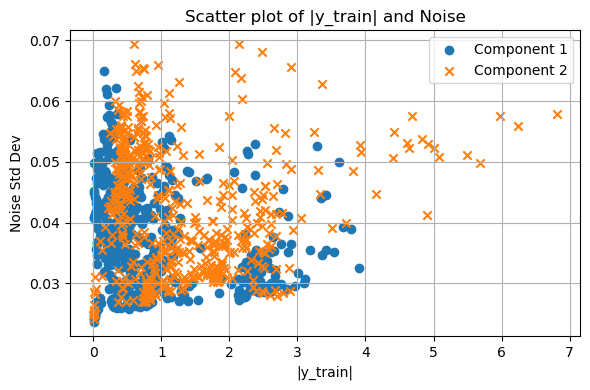

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4))
plt.scatter(torch.abs(y_train[:, 0]).cpu().numpy(), train_noise_diag[0:y_train.shape[0]].cpu().numpy(), label='Component 1', marker='o')
plt.scatter(torch.abs(y_train[:, 1]).cpu().numpy(), train_noise_diag[y_train.shape[0]:].cpu().numpy(), label='Component 2', marker='x')

plt.xlabel('|y_train|')
plt.ylabel('Noise Std Dev')
plt.title('Scatter plot of |y_train| and Noise')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
torch.square(1 / torch.tensor([0.5, 0.1])).sum()

tensor(104.)

In [54]:
# Compute all pairwise differences
diffs = x_test.unsqueeze(1) - x_train.unsqueeze(0)  # (N_test, N_train, d)

# Compute Euclidean distances directly
dists = torch.norm(diffs, dim = 2) # (N_test, N_train)

# For each test point, find the min distance to any train point (closest train point)
max_dist_per_test = torch.min(dists, dim = 1).values  # (N_test,)

# Find the largest of these maximum distances
final_max_dist = torch.max(max_dist_per_test)

print(f"Final maximum distance: {final_max_dist.item():.3f}")

Final maximum distance: 0.171


In [1]:
import torch

In [21]:
from utils import make_grid
x_grid, x_grid_long = make_grid(15)

from simulate import simulate_convergence, simulate_merge

conv = simulate_convergence(x_grid_long)
merge = simulate_merge(x_grid_long) * 0.5

sum = conv + merge

from matplotlib import pyplot as plt

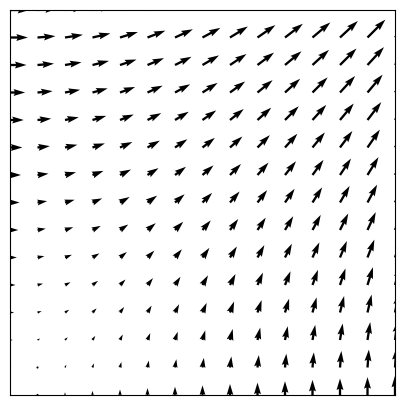

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.quiver(
    x_grid_long[:, 0], 
    x_grid_long[:, 1],
    conv[:, 0],
    conv[:, 1],
    scale = 20, width = 0.006)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
    
ax.set_aspect("equal")

plt.show()

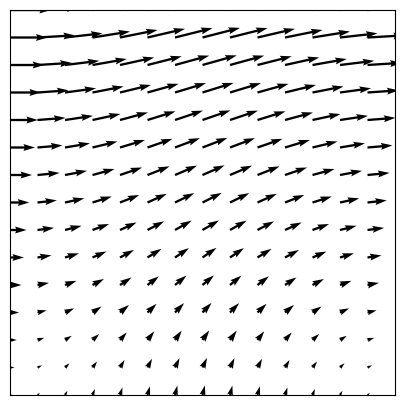

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.quiver(
    x_grid_long[:, 0], 
    x_grid_long[:, 1],
    sum[:, 0],
    merge[:, 1],
    scale = 20,  width = 0.006)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
    
ax.set_aspect("equal")

plt.show()

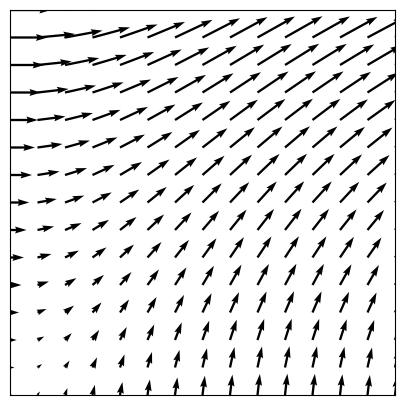

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.quiver(
    x_grid_long[:, 0], 
    x_grid_long[:, 1],
    sum[:, 0],
    sum[:, 1],
    scale = 20,  width = 0.006)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
    
ax.set_aspect("equal")

plt.show()